# Machine Learning for Author Attribution - Analysis

## Genevieve Hayes
### 13th November 2018

Add: Google Colaboratoryで動かしているので、Google Driveのアクセスを許可させる

In [11]:
# Add: by s1280124
# Google Colaboratoryで動かしているので、Google Driveのアクセスを許可させる
from google.colab import drive
drive.mount('/content/drive')

# このプロジェクトの為のディレクトリまで移動する
# 使う人や環境によって変更してください
import os
os.chdir('/content/drive/MyDrive/Colab/ENG4')
print(f'Move to:　{os.getcwd()}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Move to:　/content/drive/MyDrive/Colab/ENG4


### Overview

Author attribution "is the task of identifying the author of a given text from a (given) set of suspects (Mohsen et al. (2016))." This is a problem that can readily be framed as a text classification task, "where author represents a class (label) of a given text (Mohsen et al. (2016))," and as a result, recent research into author attribution analysis has focussed almost exclusively on the use of machine learning techniques.

Prior to the advent of social media, author attribution analysis was typically applied to longer texts, such as books and letters. In fact, Forsyth and Holmes (1996) concluded that a text had to be a minimum of 250 words in length for the stylometric characteristics to be apparent. However, recent research (for example, Green and Sheppard (2013), Schwartz et al. (2013) and Shrestha et al. (2017)) has demonstrated the successful application of author attribution techniques to Twitter messages ("tweets"), which "average less than 25 words" in length and are "often less than 10" words long (Green and Sheppard (2013)). 

Tweets are currently limited to 280 characters, and prior to November 2017, were limited to 140 characters. As a result, "tweets are relatively self-contained and have smaller sentence length variance compared to excerpts from longer text (Schwartz et al. (2013))." It is possible that these characteristics are the reason why author attribution techniques, that have previously fallen apart when applied to shorter texts, have succeeded when applied to tweets. It is also possible that, had Forsyth and Holmes (1996) considered more modern machine learning algorithms in their analysis, such as support vector machines (SVMs) and neural networks, which were not in common use in 1996, that they would have drawn different conclusions about the minimum text length required to successfully identify the author of a text. 

In this analysis we explore these hypotheses by applying techniques that have been demonstrated to succeed in determining the authorship of tweets, to short, tweet-length, excerpts of longer works. In performing this analysis, we make use of a dataset comprising 68,000 sentence-long excerpts from the (fiction) works of eight classic authors. 

The dataset was created using novel texts sourced from [Project Gutenburg](https://www.gutenberg.org/), with chapter/section headings manually removed from the files prior to processing. To allow for the creation of a balanced dataset, for authors whose novels tended to be shorter in length, text excerpts were taken from multiple works.

The novels used to create the dataset are as follows:

|Author     | Novels| Genre | Year of Publication|
|---------  |-------|-------|--------------------|
|Louisa May Alcott | *Little Women* |Coming of Age/Romance | 1869 |
|Jane Austen| *Pride and Prejudice* and *Emma*|Romance | 1813/1815 |
|Charlotte Bronte| *Jane Eyre* | Gothic Romance | 1847 |
|Wilkie Collins | *The Woman in White* | Mystery | 1859 |
|Arthur Conan Doyle | *A Study in Scarlet*, *The Sign of the Four* and *The Hound of the Baskervilles*| Mystery |1887/1890/1902| 
|L.M. Montgomery | *Anne of Green Gables* and *Anne of Avonlea* |Coming of Age | 1908/1909 |
|Bram Stoker | *Dracula* | Horror | 1897|
|Mark Twain | *The Adventures of Tom Sawyer* and *The Adventures of Huckleberry Finn*|Coming of Age/Adventure|1876/1884|

### References

Forsyth, R. and D. Holmes (1996). Feature finding for text classification. Literary and Linguistic Computing 11 (4), 163–174.

Green, R. and J. Sheppard (2013). Comparing frequency- and style-based features for Twitter author identification. Proceedings of the Twenty-Sixth International Florida Artificial Intelligence Research Society Conference, 64–69.

Mohsen, A., N. El-Makky, and N. Ghanem (2016). Author identification using deep learning. Proceedings of the 15th IEEE International Conference on Machine Learning and Applications, 898–903.

Schwartz, R., O. Tsur, A. Rappoport, and M. Koppel (2013). Authorship attribution of micro-messages. Proceedings of the 2013 Conference on Empirical Methods in Natural Language Processing. Seattle, Washington, USA, 1880–1891.

Shrestha, P., S. Sierra, F. Gonz´alez, P. Rosso, M. Montes-y G´omez, and T. Solorio (2017). Convolutional neural networks for authorship attribution of short texts. Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics: Volume 2, Short Papers. Valencia, Spain, 669–674.

### Import Packages and Load Data

In [67]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
# % matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D

# from keras.layers.merge import concatenate
from tensorflow.keras.layers import concatenate # モジュールの仕様が変更されていたため合わせる

from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

In [15]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# Get encoding of data file
# with open("/data/author_data.csv", 'rb') as file:
with open("./data/author_data.csv", 'rb') as file: # 相対パスへ変更
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [22]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="Windows-1252")

# Floydhub version
# data = pd.read_csv("/data/author_data.csv", encoding="Windows-1252")
data = pd.read_csv("./data/author_data.csv", encoding="utf-8") # 相対パスへ変更, utf-8へ変更
print(data.head())

                                                text   author
0  I'm afraid I couldn't like him without a spice...   Alcott
1  Yonder was the banks and the islands, across t...    Twain
2  Well, as I was saying about the parlor, there ...    Twain
3  Here, again, the Count had not openly committe...  Collins
4  “No,” assented Tom, “they don't kill the women...    Twain


In [23]:
# Create feature (text) and label (author) lists
text = list(data['text'].values)
author = list(data['author'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 68000 datapoints.


### Data Exploration

**Explore the author (labels) data**

In [24]:
# Check distribution of authors in the data
Counter(author)

Counter({'Alcott': 8500,
         'Twain': 8500,
         'Collins': 8500,
         'Doyle': 8500,
         'Stoker': 8500,
         'Austen': 8500,
         'Montgomery': 8500,
         'Bronte': 8500})

As expected, our data is a balanced dataset containing 8,500 text excerpts from each of the 8 authors under consideration. There do not appear to be any corrupt or missing labels.

**Explore the text data**

Here are some examples of what the text data looks like:

In [25]:
print(text[4000])

“Could you see the rags by the light of the cigars”?


In [26]:
print(text[27000])

Laura's objection seems to me a perfectly fair one, and speaking for myself only, I cannot assume the responsibility of witnessing her signature, unless she first understands what the writing is which you wish her to sign".


In [27]:
print(text[45000])

They MIGHT be good people, of course; but you were on the safe side in doubting it.


In [28]:
print(text[60000])

My heart was sore for you when I heard that," and he shook hands again, with such a sympathetic face that Jo felt as if no comfort could equal the look of the kind eyes, the grasp of the big, warm hand.


Calculate and examine word count/length and character count statistics:

In [29]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [30]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [31]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 266
Mean: 17.877882352941178
Median 14.0
1st percentile 1.0
95th percentile 44.0
99th percentile 67.0
99.5th Percentile 78.0
99.9th Percentile 111.0


<ipython-input-32-6002e2826dcd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")


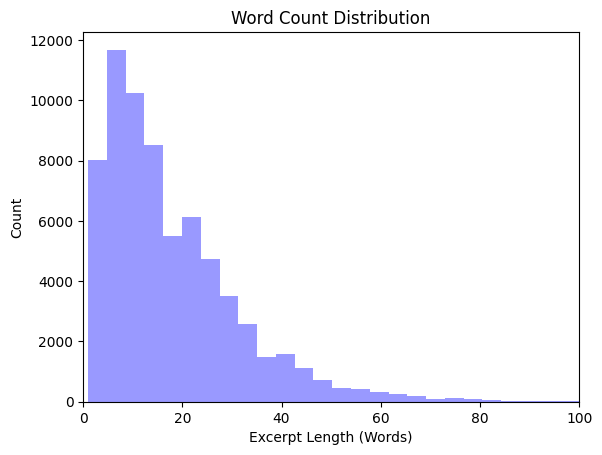

In [32]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

In [33]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 5
Max: 1370
Mean: 94.97475
Median 75.0
1st percentile 7.0
95th percentile 241.0
99th percentile 365.0
99.5th Percentile 427.0
99.9th Percentile 602.0010000000038


<ipython-input-34-8e4bef13dec1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")


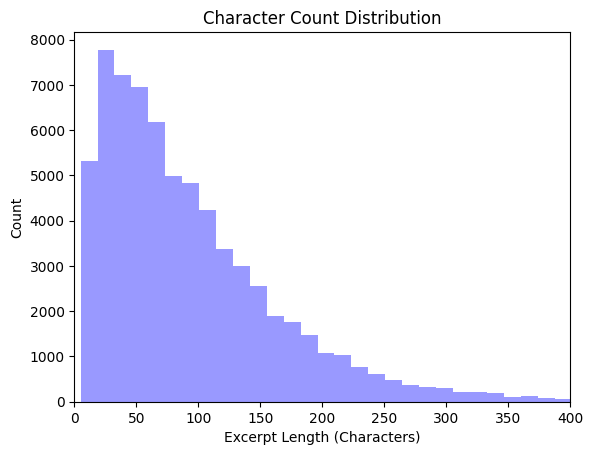

In [34]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")

In [35]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 2.5
Max: 22.0
Mean: 5.339657862688342
Median 5.25
1st percentile 3.857142857142857
95th percentile 6.6
99th percentile 8.0
99.5th Percentile 9.0
99.9th Percentile 12.0


<ipython-input-36-e0a359e7a16a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")


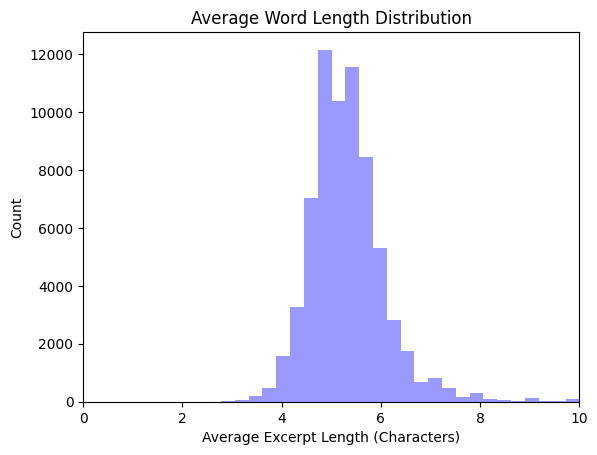

In [36]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

The vast majority of text excerpts are under 100 words long, with an average length of around 18 words. However, there are a small number of outliers, including one excerpt containing over 250 words. At the opposite end of the spectrum, 1 percent of the text excerpts contain only 1 word each.

On average, the text excerpts contain around 95 characters each, with the longest containing 1370 characters and the shortest, just 5 characters (sentences containing fewer than 5 characters were removed during the creation of the dataset). We would expect there to be a high correlation between word count and character count, so as a result, we shall just focus on further examining word count outliers, going forward and assume these are the same as the character count outliers.

With regard to word length, the majority of the excerpts have an average word length of around 5.3 characters. However, there are also outliers in this distribution, including one excerpt with an average word length of 22.0 characters, and at the other end of the spectrum, an excerpt with an average word length of 2.5 characters.

We explore these outliers below.

In [37]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 280 - Length: 152
A good, generous prayer it was, and went into details: it pleaded for the church, and the little children of the church; for the other churches of the village; for the village itself; for the county; for the State; for the State officers; for the United States; for the churches of the United States; for Congress; for the President; for the officers of the Government; for poor sailors, tossed by stormy seas; for the oppressed millions groaning under the heel of European monarchies and Oriental despotisms; for such as have the light and the good tidings, and yet have not eyes to see nor ears to hear withal; for the heathen in the far islands of the sea; and closed with a supplication that the words he was about to speak might find grace and favor, and be as seed sown in fertile ground, yielding in time a grateful harvest of good. 

Excerpt 13635 - Length: 228
A rail fence round a two-acre yard; a stile made out of logs sawed off and up-ended in steps, like barre

In [38]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 17 - Length: 1
“Yes”. 

Excerpt 68 - Length: 1
Weston.] 

Excerpt 122 - Length: 1
Why?" 

Excerpt 220 - Length: 1
"Hindostanee". 

Excerpt 250 - Length: 1
me-yow”! 

Excerpt 312 - Length: 1
“Nobody. 

Excerpt 350 - Length: 1
“No”. 

Excerpt 411 - Length: 1
“Sir”! 

Excerpt 464 - Length: 1
“No”. 

Excerpt 484 - Length: 1
Hudson?' 

Excerpt 486 - Length: 1
"Yes. 

Excerpt 611 - Length: 1
"What!" 

Excerpt 719 - Length: 1
"Genius. 

Excerpt 765 - Length: 1
solution. 

Excerpt 775 - Length: 1
Politics. 

Excerpt 785 - Length: 1
“Sometimes. 

Excerpt 832 - Length: 1
Read". 

Excerpt 847 - Length: 1
“Why”? 

Excerpt 853 - Length: 1
"When?" 

Excerpt 1073 - Length: 1
'Never! 

Excerpt 1085 - Length: 1
“Indeed! 

Excerpt 1261 - Length: 1
“Mrs. 

Excerpt 1332 - Length: 1
“‘P.S. 

Excerpt 1554 - Length: 1
"Followed! 

Excerpt 1609 - Length: 1
my-soul-bless-my-soul! 

Excerpt 1610 - Length: 1
Well! 

Excerpt 1636 - Length: 1
“No”. 

Excerpt 1758 - Length: 1
Hartright!" 

Excerpt 1851 - Le

Even though it is unusual to have text excerpts as long or as short as the outliers in our dataset, examination of these excerpts indicates that they do all appear to be proper sentences, so no adjustments need to be made.

We now perform similar checks with the average length data.

In [39]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 173 - Average Length: 10.5
Beth's stage-struck!" 

Excerpt 220 - Average Length: 14.0
"Hindostanee". 

Excerpt 785 - Average Length: 11.0
“Sometimes. 

Excerpt 1609 - Average Length: 22.0
my-soul-bless-my-soul! 

Excerpt 1758 - Average Length: 11.0
Hartright!" 

Excerpt 1925 - Average Length: 11.5
“Promote fiddlesticks”! 

Excerpt 2870 - Average Length: 12.0
'Bank-note!' 

Excerpt 2889 - Average Length: 11.0
Backsheesh. 

Excerpt 2965 - Average Length: 22.0
My-soul-bless-my-soul! 

Excerpt 3086 - Average Length: 12.0
"Destroyed?" 

Excerpt 3224 - Average Length: 11.0
Laurence!'" 

Excerpt 3263 - Average Length: 11.0
Hartright?" 

Excerpt 3337 - Average Length: 11.0
"Certainly. 

Excerpt 4734 - Average Length: 10.5
"Remember to-morrow!" 

Excerpt 4852 - Average Length: 18.0
“Three-and-twenty! 

Excerpt 4880 - Average Length: 12.0
"Certainly". 

Excerpt 5675 - Average Length: 17.0
Ting-a-ling-ling! 

Excerpt 5861 - Average Length: 11.5
"Absolutely determined. 

Excerpt 5985 - Ave

In [40]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 120 - Average Length: 3.4
I do not see it”. 

Excerpt 439 - Average Length: 3.3333333333333335
Am I ill?" 

Excerpt 1199 - Average Length: 3.4
Now I saw no bad. 

Excerpt 1413 - Average Length: 3.25
I see it all! 

Excerpt 1933 - Average Length: 2.5
But . 

Excerpt 2074 - Average Length: 3.25
I rose to go. 

Excerpt 2111 - Average Length: 2.5
Am I? 

Excerpt 2700 - Average Length: 3.3333333333333335
I said so. 

Excerpt 2794 - Average Length: 2.6666666666666665
So am I. 

Excerpt 2882 - Average Length: 3.3333333333333335
let me go! 

Excerpt 2888 - Average Length: 3.0
Not I! 

Excerpt 2984 - Average Length: 3.2857142857142856
I see I was up a stump. 

Excerpt 4159 - Average Length: 3.0
Go on. 

Excerpt 4246 - Average Length: 3.0
So it is. 

Excerpt 5105 - Average Length: 3.3333333333333335
Woe is me! 

Excerpt 6697 - Average Length: 3.25
So I done it. 

Excerpt 6972 - Average Length: 3.3333333333333335
So I quit. 

Excerpt 7325 - Average Length: 3.3333333333333335
How can I? 



Large average word lengths tend to be associated with short sentences containing a small number of long words, and similarly, small average word lengths tend to be associated with short sentences containing a small number of short words. There is nothing wrong with this, so no adjustments need to be made.

It should be noted that this analysis revealed several sentences with large blocks of white space within them. We shall remove these blocks of white space during preprocessing.

**Explore the words and characters**

Next we look at the characters that make up the text excerpts, to check for any strange characters.

In [41]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 1157092, 'e': 627136, 't': 451237, 'a': 409675, 'o': 389824, 'n': 348067, 'i': 344868, 'h': 317481, 's': 312893, 'r': 288591, 'd': 232160, 'l': 211060, 'u': 147257, 'm': 137853, 'w': 127545, 'c': 113126, 'y': 112329, 'f': 107854, 'g': 102562, ',': 89890, 'p': 78758, 'b': 76660, '.': 63034, 'v': 48234, 'k': 44214, '"': 22813, "'": 17378, ';': 9705, 'j': 8704, '“': 8045, '”': 7951, 'x': 6966, '?': 6539, '-': 6398, '’': 5311, '!': 4932, 'q': 4861, ':': 3839, 'z': 2388, '*': 677, ')': 491, '(': 490, '‘': 279, '1': 193, '2': 168, '3': 91, '0': 80, '8': 65, '5': 64, '7': 62, '4': 61, '6': 44, '&': 39, ']': 38, '[': 38, '9': 38, '\xa0': 35, '{': 17, '}': 16, 'è': 11, '\ufeff': 10, 'ö': 9, 'é': 8, 'æ': 7, 'ñ': 3, '£': 3, 'à': 3, 'ë': 3, 'ï': 2, 'â': 2, 'ê': 2, '$': 2, 'ô': 1, 'á': 1})
74


There are a number of unusual characters in the text excerpts. '\xa0' is not a valid character, so should be removed. The accented characters, on the other hand, may or may not be valid, so should be explored further. 

In [42]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['i', "'", 'm', ' ', 'a', 'f', 'r', 'd', 'c', 'o', 'u', 'l', 'n', 't', 'k', 'e', 'h', 'w', 's', 'p', 'g', '.', 'y', 'b', ',', ';', 'v', ':', '\xa0', '“', '”', '-', '"', '?', '!', 'j', 'x', '’', 'z', 'q', ']', '(', ')', '2', '5', '1', '8', '0', '7', '‘', '3', '4', '[', '{', 'ï', 'é', 'ñ', '&', '6', '*', 'è', '\ufeff', '}', '9', 'ö', 'æ', 'ô', '£', 'â', 'á', 'à', 'ê', 'ë', '$']


In [43]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print('There are', str(len(accented_text)), 'texts containing accented characters.')

There are 48 texts containing accented characters.


In [44]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

Excerpt 5892
Carére has blurred my recollection of Baskerville Hall.

Excerpt 56197
I leaned back in the embrasure in a more comfortable position, so that I could enjoy more fully the aërial gambolling.

Excerpt 61060
To which he smiled a sad sort of smile as he replied:   "He is her lover, her fiancé.

Excerpt 60169
If there be anything behind this instinct it will be valuable to trace it afterwards accurately, so I had better commence to do so, therefore   R. M. Renfield, ætat 59.

Excerpt 9484
Omnia Romæ venalia sunt.

Excerpt 19984
Our correspondent naïvely says that even Ellen Terry could not be so winningly attractive as some of these grubby-faced little children pretend and even imagine themselves to be.

Excerpt 28692
But the conditions of her are in no way anæmic.

Excerpt 4629
Lucy came with me, and we went early to our old seat, whilst the cortège of boats went up the river to the Viaduct and came down again.

Excerpt 39449
He smiled on me in quite a superior sort of way suc

The texts containing accented characters do appear to be legitimate foreign words and not corrupt strings. As a result, no corrections are required.

**Summary**

Based on the above analysis, our data appears to be in reasonably good shape. The only abnormalities that have been identified that require correction are the presence of several invalid characters and the presence of several large blocks of white space. These shall be removed during the pre-processing stage.

### Data Preprocessing

**Remove invalid characters and large blocks of white space**

As discussed in the previous section, the first step required to preprocess the data is to remove any invalid characters or large blocks of white space. 

In [45]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]

In [46]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [47]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 2657 excerpts containing blocks of white space.


In [48]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

68000


In [49]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


**Remove punctuation and convert to lowercase**

To normalize the excerpts, we remove all punctuation and convert them to lowercase.

In [50]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['im afraid i couldnt like him without a spice of human naughtiness', 'yonder was the banks and the islands across the water and maybe a spark which was a candle in a cabin window and sometimes on the water you could see a spark or two on a raft or a scow you know and maybe you could hear a fiddle or a song coming over from one of them crafts', 'well as i was saying about the parlor there was beautiful curtains on the windows white with pictures painted on them of castles with vines all down the walls and cattle coming down to drink', 'here again the count had not openly committed himself here again he was to all practical purpose out of my reach', 'no assented tom they dont kill the women theyre too noble']
68000


**Create training and test subsets**

In [51]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [52]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(54400,)
(13600,)
(54400,)
(13600,)


**Create n-gram sequences**

In [53]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [54]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences
    
    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [55]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 52
Vocab size for n = 2 is: 973
Vocab size for n = 3 is: 9529


In [56]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 51, 350)
gram2_train = create_n_grams(text_train, 2, 966, 350)
gram3_train = create_n_grams(text_train, 3, 9521, 350)

gram1_test = create_n_grams(text_test, 1, 51, 350)
gram2_test = create_n_grams(text_test, 2, 966, 350)
gram3_test = create_n_grams(text_test, 3, 9521, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(54400, 350)
(54400, 350)
(54400, 350)
(13600, 350)
(13600, 350)
(13600, 350)


In [57]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  61
Maximum encoding value for 2-grams is:  1255
Maximum encoding value for 3-grams is:  12374


**Create bag-of-words features**

In [58]:
def process_data(excerpt_list):
    """Stem data, remove stopwords and split into word lists
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    
    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [60]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['went jo talk fast told hummel mother interest richer friend', 'look kind weari discouragedlik say aint use tri learn noth huck', 'lost', 'happi dont know done deserv', 'certainli must go alon']


In [61]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  5840


**One-hot encode labels**

In [62]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

### Implementation

**Fit the CNN**

In [63]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [68]:
# Create the 1-gram model
gram1_model = define_model(350, 8, max_1gram + 1, 26)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 350, 26)      1612        ['input_7[0][0]']                
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [69]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1360/1360 [==============================] - 697s 510ms/step - loss: 2.0500 - accuracy: 0.1729 - val_loss: 2.0157 - val_accuracy: 0.1951
Epoch 2/10
1360/1360 [==============================] - 658s 484ms/step - loss: 1.9705 - accuracy: 0.2319 - val_loss: 1.9589 - val_accuracy: 0.2367
Epoch 3/10
1360/1360 [==============================] - 643s 473ms/step - loss: 1.8985 - accuracy: 0.2755 - val_loss: 1.9516 - val_accuracy: 0.2440
Epoch 4/10
1360/1360 [==============================] - 689s 507ms/step - loss: 1.8301 - accuracy: 0.3112 - val_loss: 1.9156 - val_accuracy: 0.2671
Epoch 5/10
1360/1360 [==============================] - 651s 479ms/step - loss: 1.7624 - accuracy: 0.3456 - val_loss: 1.9200 - val_accuracy: 0.2730
Epoch 6/10
1360/1360 [==============================] - 641s 471ms/step - loss: 1.6970 - accuracy: 0.3727 - val_loss: 1.8853 - val_accuracy: 0.2928
Epoch 7/10
1360/1360 [==============================] - 639s 470ms/step - loss: 1.6322 - accuracy: 0.4047 - val_

In [71]:
# Create the 2-gram model
gram2_model = define_model(350, 8, max_2gram + 1, 300)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 350, 300)     376800      ['input_10[0][0]']               
                                                                                            

In [ ]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1360/1360 [==============================] - 3792s 3s/step - loss: 1.9733 - accuracy: 0.2217 - val_loss: 1.7613 - val_accuracy: 0.3313
Epoch 2/10
1360/1360 [==============================] - 3786s 3s/step - loss: 1.6004 - accuracy: 0.4162 - val_loss: 1.5738 - val_accuracy: 0.4224
Epoch 3/10
1360/1360 [==============================] - 3734s 3s/step - loss: 1.3980 - accuracy: 0.5013 - val_loss: 1.4865 - val_accuracy: 0.4574
Epoch 4/10
1360/1360 [==============================] - ETA: 0s - loss: 1.2558 - accuracy: 0.5599

In [ ]:
# Create the 3-gram model
gram3_model = define_model(350, 8, max_3gram + 1, 600)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 350, 600)     7426200     input_22[0][0]                   
__________________________________________________________________________________________________
embedding_

In [ ]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Train on 43520 samples, validate on 10880 samples
Epoch 1/10
43520/43520 [==============================] - 310s 7ms/step - loss: 1.9104 - acc: 0.2558 - val_loss: 1.5276 - val_acc: 0.4344
Epoch 2/10
43520/43520 [==============================] - 302s 7ms/step - loss: 1.2773 - acc: 0.5477 - val_loss: 1.2492 - val_acc: 0.5505
Epoch 3/10
43520/43520 [==============================] - 300s 7ms/step - loss: 0.9639 - acc: 0.6689 - val_loss: 1.1923 - val_acc: 0.5745
Epoch 4/10
43520/43520 [==============================] - 300s 7ms/step - loss: 0.7682 - acc: 0.7434 - val_loss: 1.1953 - val_acc: 0.5821
Epoch 5/10
43520/43520 [==============================] - 300s 7ms/step - loss: 0.6162 - acc: 0.8031 - val_loss: 1.2445 - val_acc: 0.5801
Epoch 6/10
43520/43520 [==============================] - 300s 7ms/step - loss: 0.4869 - acc: 0.8519 - val_loss: 1.3272 - val_acc: 0.5730
Epoch 7/10
43520/43520 [==============================] - 300s 7ms/step - loss: 0.3747 - acc: 0.8952 - val_loss: 1.3939 - 

The best results with regard to validation accuracy were achieved by the 3-gram CNN (followed by the 2-gram CNN, then the 1-gram CNN). 

In the case of the 3-gram and 2-gram CNNs, validation accuracy tends to plateau after around 5 epochs, so for the remainder of this analysis, we shall reduce the number of epochs for fitting the CNN down to 5.

**Fit the SVM**

In [ ]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [ ]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.5875606528451698, total= 2.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.5991286604533171, total= 2.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.7min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.5905355468534554, total= 2.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.0min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.5604322893692104, total= 2.7min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[CV] C=10, kernel=linear ............................

In [ ]:
print(word_svm.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [ ]:
print(word_svm.cv_results_)

{'mean_fit_time': array([107.98448531, 136.42942905, 425.95507264]), 'std_fit_time': array([0.62575926, 0.62474636, 9.53641656]), 'mean_score_time': array([30.77192775, 27.47356653, 26.70237382]), 'std_score_time': array([0.07407209, 0.05506556, 0.03792019]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.58756065, 0.56043229, 0.53049184]), 'split1_test_score': array([0.59912866, 0.57017592, 0.54111289]), 'split2_test_score': array([0.59053555, 0.56180023, 0.53218245]), 'mean_test_score': array([0.59240809, 0.56413603, 0.53459559]), 'std_test_score': array([0.00490484, 0.00430715, 0.00465976]), 'rank_test_score': 

The best results were achieved when C = 1.

### Refinement

**Add extra channel to CNN**

Refit the CNN to the 3-gram sequences with an extra channel added to the model (with kernel size = 6). Stop after five epochs this time.

In [ ]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [ ]:
# Create the 3-gram model
gram3_model2 = define_model2(350, 8, max_3gram + 1, 600)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_

In [ ]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Train on 43520 samples, validate on 10880 samples
Epoch 1/5
43520/43520 [==============================] - 435s 10ms/step - loss: 1.8808 - acc: 0.2714 - val_loss: 1.4971 - val_acc: 0.4487
Epoch 2/5
43520/43520 [==============================] - 430s 10ms/step - loss: 1.2242 - acc: 0.5688 - val_loss: 1.2269 - val_acc: 0.5608
Epoch 3/5
43520/43520 [==============================] - 430s 10ms/step - loss: 0.9018 - acc: 0.6913 - val_loss: 1.1853 - val_acc: 0.5801
Epoch 4/5
43520/43520 [==============================] - 434s 10ms/step - loss: 0.6964 - acc: 0.7736 - val_loss: 1.2006 - val_acc: 0.5860
Epoch 5/5
43520/43520 [==============================] - 434s 10ms/step - loss: 0.5283 - acc: 0.8375 - val_loss: 1.2743 - val_acc: 0.5741


After 5 epochs, the 4-channel model has a slightly lower validation accuracy than the 3-channel model (0.5741 vs 0.5801). Consequently, we will stick with the original 3-channel model.

### Model Evaluation and Validation

**Fit final models and evaluate**

In [ ]:
# Define function for plotting normalized confusion matrix
# Code reference 1: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Code reference 2: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
    cm: matrix. Confusion matrix for plotting.
    classes: list. List of class labels.
    normalize: bool. Whether or not to normalize the confusion matrix.
    title: string. Title for plot.
    cmap: color map. Color scheme for plot.
    
    Returns:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [ ]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 8, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)

# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = ['Alcott', 'Austen', 'Bronte', 'Collins', 
                                                                  'Doyle', 'Montgomery', 'Stoker', 'Twain'])
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 350, 600)     7426200     input_32[0][0]                   
__________________________________________________________________________________________________
embedding_

Normalized confusion matrix
[[0.61486898 0.05057892 0.04082876 0.031688   0.05301645 0.03107861
  0.07800122 0.09993906]
 [0.04166667 0.60787671 0.05479452 0.07534247 0.07762557 0.02625571
  0.08105023 0.03538813]
 [0.06646884 0.08130564 0.40178042 0.09732938 0.12462908 0.02373887
  0.12759644 0.07715134]
 [0.04603271 0.06602059 0.06965475 0.51120533 0.11568746 0.01514234
  0.10478498 0.07147184]
 [0.03603604 0.05292793 0.05518018 0.07657658 0.51013514 0.03828829
  0.14414414 0.08671171]
 [0.06157635 0.04248768 0.02647783 0.02463054 0.04987685 0.69642857
  0.04064039 0.05788177]
 [0.04372842 0.03797468 0.04775604 0.06214039 0.11622555 0.02071346
  0.59666283 0.07479862]
 [0.07270629 0.02596653 0.03115984 0.0253895  0.06231968 0.0288517
  0.06635892 0.68724755]]


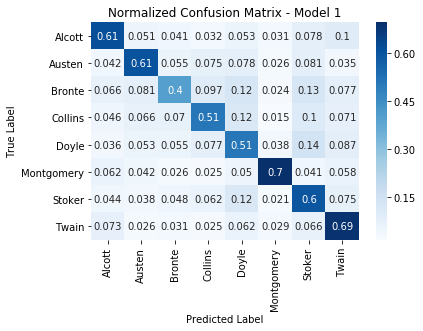

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Alcott', 'Austen', 'Bronte', 'Collins', 
                                          'Doyle', 'Montgomery', 'Stoker', 'Twain'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

In [ ]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()

# Predict values for test set
author_pred2 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support = score(author_test, author_pred2)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels =  ['Alcott', 'Austen', 'Bronte', 'Collins', 
                                                                  'Doyle', 'Montgomery', 'Stoker', 'Twain'])

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.5981617647058823
Ave. Precision: 0.6057913357704325
Ave. Recall: 0.5981617647058823
Ave. F1 Score: 0.6005337108664128
Training Time: 218.93059182167053 seconds
Prediction Time: 32.63461709022522 seconds
Confusion Matrix:
 [[1028   85  101   59   96   87   90   95]
 [  65 1194  135  106  113   40   62   37]
 [  66  148  883  138  196   38  140   76]
 [  62  134  161  890  197   28  118   61]
 [  59  117  181  166  997   29  136   91]
 [ 122   54   78   61   87 1051   64  107]
 [  58   84  141  141  196   24 1010   84]
 [  93   47   99   83  204   51   74 1082]]


Normalized confusion matrix
[[0.62644729 0.05179768 0.06154784 0.03595369 0.05850091 0.05301645
  0.05484461 0.05789153]
 [0.03710046 0.68150685 0.07705479 0.06050228 0.06449772 0.02283105
  0.03538813 0.02111872]
 [0.03916914 0.08783383 0.52403561 0.08189911 0.11632047 0.02255193
  0.08308605 0.04510386]
 [0.037553   0.08116293 0.09751666 0.53906723 0.11932162 0.01695942
  0.07147184 0.0369473 ]
 [0.03322072 0.06587838 0.10191441 0.09346847 0.56137387 0.01632883
  0.07657658 0.05123874]
 [0.07512315 0.03325123 0.04802956 0.03756158 0.05357143 0.64716749
  0.03940887 0.0658867 ]
 [0.03337169 0.04833142 0.08112773 0.08112773 0.1127733  0.01380898
  0.58112773 0.04833142]
 [0.05366417 0.0271206  0.05712637 0.04789383 0.11771495 0.02942874
  0.04270052 0.62435084]]


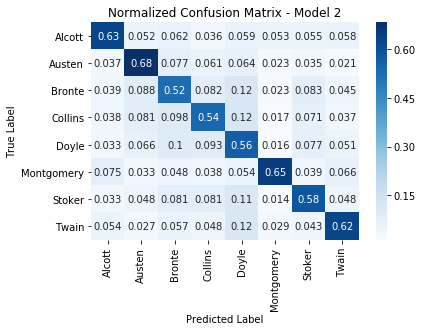

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Alcott', 'Austen', 'Bronte', 'Collins', 
                                          'Doyle', 'Montgomery', 'Stoker', 'Twain'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")

In [ ]:
# Get benchmark statistics (random model)

# Perform 10 times and take averages

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    # Create random predictions
    author_pred3 = np.random.choice(['Alcott', 'Austen', 'Bronte', 'Collins', 
                                'Doyle', 'Montgomery', 'Stoker', 'Twain'], len(author_test))

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print("Ave. Precision:", prec_list, np.mean(prec_list), np.std(prec_list))
print("Ave. Recall:", recall_list, np.mean(recall_list), np.std(recall_list))
print("Ave. F1 Score:", f1_list, np.mean(f1_list), np.std(f1_list))

Accuracy: [0.1264705882352941, 0.12227941176470589, 0.12316176470588236, 0.13014705882352942, 0.12176470588235294, 0.12625, 0.12360294117647058, 0.13088235294117648, 0.12426470588235294, 0.12588235294117647] 0.12547058823529414 0.002951672448327311
Ave. Precision: [0.1266465444835753, 0.12233628218025662, 0.12342378106218606, 0.1304336723166218, 0.12189731573734387, 0.1262912622665182, 0.12386941963618259, 0.13109834759020694, 0.12437353571106353, 0.12583728670790226] 0.12562074476918572 0.00298023642284441
Ave. Recall: [0.1264705882352941, 0.12227941176470589, 0.12316176470588235, 0.1301470588235294, 0.12176470588235294, 0.12625, 0.1236029411764706, 0.13088235294117648, 0.12426470588235294, 0.12588235294117647] 0.12547058823529414 0.0029516724483273074
Ave. F1 Score: [0.12653319286141212, 0.12226843324399686, 0.12321947748660764, 0.1302077902363022, 0.12178652876626787, 0.12622344999942142, 0.1236886176229508, 0.13092308650117446, 0.12424972751678684, 0.12580242802232933] 0.1254902732

**Perform sensitivity analysis**

Sensitivity analysis is performed by creating 3 random (67%) subsets of the training data set and fitting the model to each subset then calculating the evaluation (test) metrics and examining the variability in these metrics.

In [ ]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0


for train_inds, _ in kf.split(gram3_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    # Fit model
    model1 = define_model(350, 8, max_3gram + 1, 600, verbose = False)
    model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, verbose = 0)
    
    # Predict values for test set
    author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.5897058823529412, 0.5874264705882353, 0.5864705882352941]
Ave. Precision: [0.5915751826257802, 0.5870073771495099, 0.5858526707769397]
Ave. Recall: [0.5897058823529413, 0.5874264705882353, 0.5864705882352941]
Ave. F1 Score: [0.5896756066274966, 0.5848992707332438, 0.5849639228181289]


In [ ]:
# Model 2 sensitivity testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0

# Convert sparse matrix to array
words_train_np = words_train.toarray()

for train_inds, _ in kf.split(words_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([words_train_np[i] for i in train_inds])
    train_y = [author_train[i] for i in train_inds]
    
    # Convert train_x back to sparse matrix
    train_x = sparse.csr_matrix(train_x)
    
    # Fit model
    model2 = SVC(C = 1, kernel = 'linear')
    model2.fit(train_x, train_y)


    # Predict values for test set
    author_pred2 = model2.predict(words_test)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred2)
    precision, recall, f1, support = score(author_test, author_pred2)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.5855882352941176, 0.5822058823529411, 0.5827205882352942]
Ave. Precision: [0.5934193273768217, 0.5900483541326081, 0.590777047380897]
Ave. Recall: [0.5855882352941176, 0.5822058823529412, 0.5827205882352942]
Ave. F1 Score: [0.5880048936638183, 0.5846906365078599, 0.5852778440958231]


**Explore incorrectly classified excerpts**

In [70]:
# Explore the first 100 test examples
for i in range(100):
    print('Excerpt', i, '- Actual label =', author_test[i],  'Model 1 predicted label =', author_pred1[i], 
         'Model 2 predicted label =', author_pred2[i])
    print(text_test[i], '\n')

NameError: ignored

In [ ]:
def calculate_averages(true, pred, text):
    """Calculate average length of correctly and incorrectly classified examples
    
    Args:
    true: list. List of correct labels.
    pred: list. List of predicted labels.
    text: list. List of text excerpts.
    
    Returns:
    correct_ave_chars: float. Average length of correctly classified examples in characters.
    incorrect_ave_chars: float. Average length of incorrectly classified examples in characters.
    correct_ave_words: float. Average length of correctly classified examples in characters.
    incorrect_ave_words: float. Average length of incorrectly classified examples in characters.
    """
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    # Conduct two sample t-test
    print('Character t-test')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nWord t-test')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [ ]:
# Calculate averages for Model 1
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

Character t-test
Ttest_indResult(statistic=19.820586795169806, pvalue=3.4644136380226635e-86)

Word t-test
Ttest_indResult(statistic=19.652189749779854, pvalue=8.785376635849192e-85)


In [ ]:
# Calculate averages for Model 2
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

Character t-test
Ttest_indResult(statistic=25.373326230126498, pvalue=8.825426161370996e-139)

Word t-test
Ttest_indResult(statistic=24.565458634506314, pvalue=2.1671757860881178e-130)


In [ ]:
print('Model 1 - Average excerpt length (chars) of correct examples =', correct_ave_chars1, 
        'Incorrect exampes =', incorrect_ave_chars1)
print('Model 2 - Average excerpt length (chars) of correct examples =', correct_ave_chars2, 
      'Incorrect exampes =', incorrect_ave_chars2)

print('\nModel 1 - Average excerpt length (words) of correct examples =', correct_ave_words1, 
        'Incorrect exampes =', incorrect_ave_words1)
print('Model 2 - Average excerpt length (words) of correct examples =', correct_ave_words2, 
      'Incorrect exampes =', incorrect_ave_words2)

Model 1 - Average excerpt length (chars) of correct examples = 100.94069709127382 Incorrect exampes = 76.474573257468
Model 2 - Average excerpt length (chars) of correct examples = 103.71028391167192 Incorrect exampes = 72.82678414096917

Model 1 - Average excerpt length (words) of correct examples = 19.646564694082247 Incorrect exampes = 15.088371266002845
Model 2 - Average excerpt length (words) of correct examples = 20.112933753943217 Incorrect exampes = 14.47806167400881
